In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-ivp-euler)=
# Euler's method


Let a first-order initial-value problem be given in the form

```{math}
:label: euler-ivp
\begin{split}
  u'(t) &= f\bigl(t,u(t)\bigr), \qquad a \le t \le b,\\
  u(a)& =u_0.
\end{split}
```

We represent a numerical solution of an IVP by its values at a finite collection of nodes, which for now we require to be equally spaced:

```{math}
:label: nodes-euler
t_i = a + ih, \qquad h=\frac{b-a}{n}, \qquad i=0,\ldots,n.
```

The number $h$ is called the **step size**.

Because we don't get exactly correct values of the solution at the nodes, we need to take some care with the notation. From now on we let $\hat{u}(t)$ denote the exact solution of the IVP. The approximate value at $t_i$ computed at the nodes by our numerical methods will be denoted by $u_i\approx \hat{u}(t_i)$. Because we are given the initial value $u(a)=u_0$ exactly, there is no need to distinguish whether we mean $u_0$ as the exact or the numerical solution.

Consider a piecewise linear interpolant to the (as yet unknown) values $u_0,u_1,\ldots$, $u_n$. For $t_i < t < t_{i+1}$, its slope is 

```{math}
\frac{u_{i+1} - u_{i}}{t_{i+1}-t_i} = \frac{u_{i+1}-u_i}{h}.
```

We can connect this derivative to the differential equation by following the model of $u'=f(t,u)$:

```{math}
\frac{u_{i+1}-u_i}{h} = f(t_i,u_i), \qquad i=0,\ldots,n-1.
```

```{index} ! Euler's method
```

We could view the left-hand side as a forward-difference approximation to $u'(t)$ at $t=t_i$. We can rearrange the equation to get **Euler's method**, our first method for IVPs.

(algorithm-ivp-euler)=
::::{proof:algorithm} Euler's method for an IVP
Given the IVP $u'=f(t,u)$, $u(a)=u_0$, and the nodes {eq}`nodes-euler`, iteratively compute the sequence

```{math}
  :label: euler1
  u_{i+1}=u_i + h f(t_i,u_i), \qquad i=0,\ldots,n-1.
```
Then $u_i$ is approximately the value of the solution at $t=t_i$.
::::

Euler's method marches ahead in $t$, obtaining the solution at a new time level explicitly in terms of the latest value.

A basic implementation of Euler's method is shown in {numref}`Function {number} <function-euler>`. It expects the IVP to be specified as an `ODEProblem`, as in {numref}`Demo {number} <demo-basics-first>`.  The output of {numref}`Function {number} <function-euler>` is a vector of the nodes and a vector of approximate solution values at those nodes.

(function-euler)=
````{proof:function} euler
**Euler's method for an initial-value problem**

```{code-block} julia1
:lineno-start: 1
"""
    euler(ivp,n)

Apply Euler's method to solve the given IVP using `n` time steps.
Returns a vector of times and a vector of solution values.
"""
function euler(ivp,n)
    # Time discretization.
    a,b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]

    # Initial condition and output setup.
    u = fill(float(ivp.u0),n+1)

    # The time stepping iteration.
    for i in 1:n
        u[i+1] = u[i] + h*ivp.f(u[i],ivp.p,t[i])
    end
    return t,u
end
```
````

::::{admonition} About the code
:class: dropdown
The structure created by `ODEFunction` contains the data used to define it, and it is accessed in {numref}`Function {number} <function-euler>` by dot notation, such as `ivp.f`. 
::::

## Local truncation error

Let $\hat{u}(t)$ be the exact solution of the IVP {eq}`euler-ivp`, and suppose that somehow we have access to it at $t=t_i$, so that $u_i=\hat{u}(t_i)$. How good is $u_{i+1}$ as an approximation to $\hat{u}(t_{i+1})$? The answer is revealed through a Taylor series:

```{math}
  :label: eulerLTE
\begin{split}
  \hat{u}(t_{i+1}) - \bigl[ u_i + hf(t_i,u_i) \bigr]
 &=  \hat{u}(t_{i+1}) - \bigl[ \hat{u}(t_i) + hf\bigl(t_i,\hat{u}(t_i)\bigr) \bigr] \\
 &= \bigl[ \hat{u}(t_i) + h \hat{u}'(t_i) + \tfrac{1}{2}h^2 \hat{u}''(t_i) + O(h^3) \bigr] - \bigl[ \hat{u}(t_i) + h\hat{u}'(t_i) \bigr] \notag \\
  &= \tfrac{1}{2}h^2 \hat{u}''(t_i) + O(h^3),
\end{split}
```

where we used the fact that $\hat{u}$ satisfies the differential equation.

We now introduce some formalities.

```{index} ! initial-value problem; one-step method for 
```

(definition-euler-onestep)=
::::{proof:definition} One-step IVP method
A **one-step method** for the IVP {eq}`euler-ivp` is a formula of the form

```{math}
:label: onestepODE
{u}_{i+1} = u_i + h\phi(t_i,u_i,h), \qquad i=0,\ldots,n-1.
```
::::

Euler's method is the particular case of {eq}`onestepODE` with $\phi(t,u,h) = f(t,u)$, but we will see other one-step methods in later sections. 

```{index} ! truncation error; of a one-step IVP solver
```

In close analogy with {numref}`section-localapprox-fd-converge`, we define truncation error as the residual of {eq}`onestepODE` when the exact solution is inserted. 

(definition-euler-lte)=
::::{proof:definition} Truncation error of a one-step IVP method
The **local truncation error** (LTE) of the one-step method {eq}`onestepODE` is

```{math}
  :label: onestepLTE
  \tau_{i+1}(h) := \frac{\hat{u}(t_{i+1})-\hat{u}(t_i)}{h} - \phi\bigl(t_i,\hat{u}(t_i),h\bigr).
```

The method is called **consistent** if $\tau_{i+1}(h)\to 0$ as $h\to 0$.
::::

The following follows immediately from the definitions.

:::{proof:lemma}
If $\phi(t,u,0)=f(t,u)$ for any function $u$, then the method {eq}`onestepODE` is consistent.
::::

## Convergence

While the local truncation error is straightforward to calculate from its definition, it is not the quantity we want to know about and control. 

```{index} ! global error
```

(definition-euler-global)=
::::{proof:definition} Global error of an IVP solution
Given an IVP whose exact solution is $\hat{u}(t)$, the **global error** of approximate solution values $u_0,u_1,\ldots,u_n$ at times $t_i$ in {eq}`nodes-euler` is the vector $[ \hat{u}(t_i) - u_i ]_{\,i=0,\ldots,n}$.
::::

At times the term *global error* may be interpreted as the max-norm of the global error vector, or as its final value.

By our definitions, the local error in stepping from $t_i$ to $t_{i+1}$ is $h\tau_{i+1}(h)$. To reach the time $t=b$ from $t=a$ with step size $h$, we need to take $n=(b-a)/h$ steps. If we want to reach, say, $t=(a+b)/2$, then we would have to take $n/2$ steps, and so on. In fact, to reach any fixed time in the interval, we need to take $O(n)=O(h^{-1})$ steps. By expressing the local error with a factor of $h$ taken out, the LTE $\tau$ itself is accounting for the simple accumulation of error caused by taking $O(n)$ steps.[^altLTE]

[^altLTE]: Another point of view is that we can of course make local errors smaller by chopping $h$ in half, but then we have to take twice as many steps. The important quantity, then, is local error *per unit step length*, which is how $\tau$ is defined.

However, global error is not as simple as a sum of local errors. As explained in {numref}`Theorem {number} <theorem-depIC>` and illustrated in {numref}`Demo %s <demo-basics-cond>`, each step causes a perturbation of the solution that can grow as $t$ advances. Thus, we have to account for the flow evolution of individual step truncation errors as well as their mere accumulation. That is the subject of the following theorem.

(theorem-euler-onestepGTE)=
````{proof:theorem}
Suppose that the unit local truncation error of the one-step method {eq}`onestepODE` satisfies
  
```{math}
  :label: ULTEbound
  |\tau_{i+1}(h)| \le C h^p,
```

and that

```{math}
:label: GTELip
\left| \frac{\partial \phi}{\partial u} \right| \le L
```

for all $t\in[a,b]$, all $u$, and all $h>0$. Then the global error satisfies

```{math}
:label: GTEbound
|\hat{u}(t_i) - u_i| \le \frac{Ch^p}{L} \left[ e^{L(t_i-a)} - 1
\right] = O(h^p),
```

as $h\rightarrow 0$.
````

````{proof:proof}
Define the global error sequence $ϵ_i=\hat{u}(t_i)-u_i$. Using {eq}`onestepODE`, we obtain
  
```{math}
  ϵ_{i+1} - ϵ_i = \hat{u}(t_{i+1}) - \hat{u}(t_i) - ( {u}_{i+1} - u_i ) =
  \hat{u}(t_{i+1}) - \hat{u}(t_i) - h\phi(t_i,u_i,h),
```

or

```{math}
  ϵ_{i+1} = ϵ_i + [\hat{u}(t_{i+1}) - \hat{u}(t_i) - h\phi(t_i,\hat{u}(t_i),h)] +
  h[\phi(t_i,\hat{u}(t_i),h)- \phi(t_i,u_i,h)].
```

We apply the triangle inequality,  {eq}`onestepLTE`, and {eq}`ULTEbound` to find

```{math}
  |ϵ_{i+1}| \le |ϵ_i| + Ch^{p+1} + h \left| \phi(t_i,\hat{u}(t_i),h)- \phi(t_i,u_i,h)\right|.
```

The Fundamental Theorem of Calculus implies that

```{math}
\begin{split}
  \left| \phi(t_i,\hat{u}(t_i),h)- \phi(t_i,u_i,h)\right|
      & = \left|  \int_{u_i}^{\hat{u}(t_i)} \frac{\partial \phi}{\partial u} \,du  \right|\\
    & \le  \int_{u_i}^{\hat{u}(t_i)} \left|\frac{\partial \phi}{\partial u}\right| \,du \\[1mm]
    & \le L | \hat{u}(t_i)-u_i| = L\, |ϵ_i|.
\end{split}
```

Thus

```{math}
\begin{split}
  |ϵ_{i+1}| &\le Ch^{p+1} + (1 + hL) |ϵ_i| \\
  &\le Ch^{p+1} + (1 + hL) \bigl[ Ch^{p+1} + (1 + hL) |ϵ_{i-1}|
  \bigr]\\
  &\;\vdots \\
  &\le Ch^{p+1} \left[ 1 + (1+hL) + (1+hL)^2 + \cdots + (1+hL)^i
  \right].
\end{split}
```

To get the last line we applied the inequality recursively until reaching $ϵ_0$, which is zero. Replacing $i+1$ by $i$ and simplifying the geometric sum, we get

```{math}
  |ϵ_i| \le Ch^{p+1}\frac{(1+hL)^i - 1}{(1+hL)-1} = \frac{Ch^p}{L}
  \left[ (1+hL)^i - 1 \right].
```

We observe that $1+x \le e^x$ for $x\ge 0$ (see [Exercise 5](problem-expdominate)). Hence $(1+hL)^i \le e^{i h L}$, which completes the proof.
````

```{index} ! order of accuracy; of a one-step IVP method
```

The theorem justifies one more general definition.

(definition-euler-ooa)=
::::{proof:definition} Order of accuracy of a one-step IVP method
If the local truncation error of the one-step method {eq}`onestepODE` satisfies $\tau_{i+1}(h)=O(h^p)$ for a positive integer $p$, then $p$ is the **order of accuracy** of the formula.
::::

We could restate {numref}`Theorem {number} <theorem-euler-onestepGTE>` as saying that the global error has the same order of accuracy as the LTE. Note, however, that the $O(h^p)$ convergence hides a leading constant that grows exponentially in time. When the time interval is bounded as $h\to 0$, this does not interfere with the conclusion, but the behavior as $t\to\infty$ contains no such guarantee.

(demo-euler-converge)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We consider the IVP $u'=\sin[(u+t)^2]$ over $0\le t \le 4$, with $u(0)=-1$.

In [2]:
f = (u,p,t) -> sin((t+u)^2);
tspan = (0.0,4.0);
u0 = -1.0;

ivp = ODEProblem(f,u0,tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 4.0)
u0: -1.0

Here is the call to {numref}`Function {number} <function-euler>`.

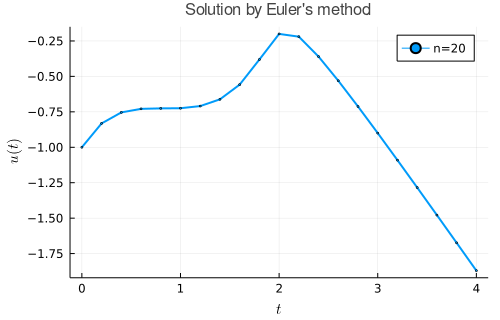

In [3]:
t,u = FNC.euler(ivp,20)

plot(t,u,m=2,label="n=20",
    xlabel=L"t",ylabel=L"u(t)",title="Solution by Euler's method" )

We could define a different interpolant to get a smoother picture above, but the derivation of Euler's method assumed a piecewise linear interpolant. We can instead request more steps to make the interpolant look smoother.

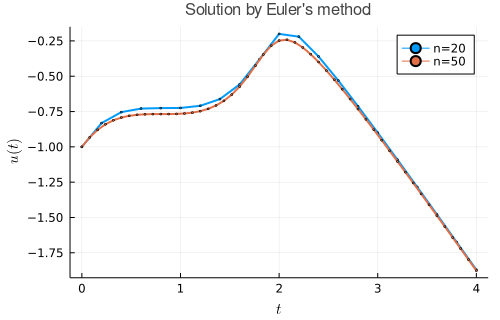

In [4]:
t,u = FNC.euler(ivp,50)
plot!(t,u,m=2,label="n=50")

Increasing $n$ changed the solution noticeably. Since we know that interpolants and finite differences become more accurate as $h\to 0$, we should anticipate the same behavior from Euler's method. We don't have an exact solution to compare to, so we will use a `DifferentialEquations` solver to construct an accurate reference solution.

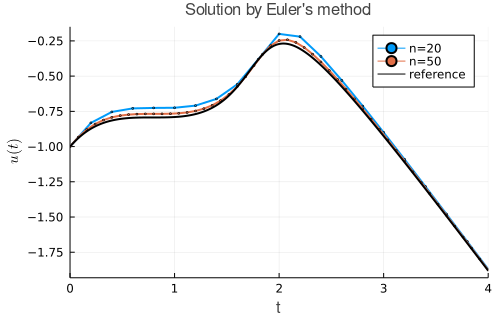

In [5]:
u_exact = solve(ivp,Tsit5(),reltol=1e-14,abstol=1e-14)

plot!(u_exact,l=(2,:black),label="reference")

Now we can perform a convergence study.

In [6]:
n = [ round(Int,5*10^k) for k in 0:0.5:3 ]
err = []
for n in n
    t,u = FNC.euler(ivp,n)
    push!( err, norm(u_exact.(t)-u,Inf) )
end

pretty_table((n=n,err=err),["n","Inf-norm error"])

┌──────┬────────────────┐
│    n │ Inf-norm error │
├──────┼────────────────┤
│    5 │         2.7342 │
│   16 │       0.107594 │
│   50 │      0.0299962 │
│  158 │     0.00885025 │
│  500 │     0.00273659 │
│ 1581 │    0.000859654 │
│ 5000 │    0.000271243 │
└──────┴────────────────┘


The error is approximately cut by a factor of 10 for each increase in $n$ by the same factor. A log-log plot also confirms first-order convergence. Keep in mind that since $h=(b-a)/n$, it follows that $O(h)=O(n^{-1})$.

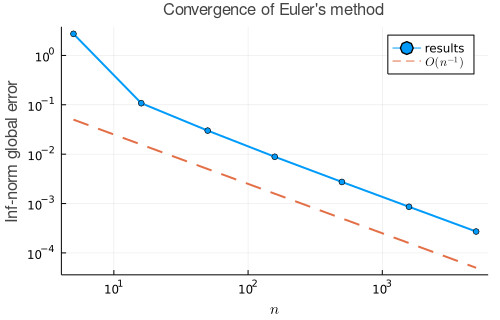

In [7]:
plot(n,err,m=:o,label="results", 
    xaxis=(:log10,L"n"), yaxis=(:log10,"Inf-norm global error"),
    title="Convergence of Euler's method")

# Add line for perfect 1st order.
plot!(n,0.05*(n/n[1]).^(-1),l=:dash,label=L"O(n^{-1})")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

Euler's method is the ancestor of the two major families of IVP methods presented in this chapter. Before we describe them, though, we generalize the initial-value problem itself in a crucial way.
## Exercises

1. ✍ Do two steps of Euler's method for the following problems using the given step size $h$. Then, compute the error using the given exact solution.

    **(a)** $u' = -2t u, \ u(0) = 2;\ h=0.1;\ \hat{u}(t) = 2e^{-t^2}$

    **(b)** $u' = u + t, \ u(0) = 2;\ h=0.2;\ \hat{u}(t) = -1-t+3e^t$

    **(c)** $t u' + u = 1, \ u(1) = 6, \ h = 0.25;\ \hat{u}(t) = 1+5/t$

    **(d)** $u' - 2u(1-u) = 0, \ u(0) = 1/2, \ h = 0.25; \ \hat{u}(t) = 1/(1 + e^{-2t})$

2. ⌨ For each IVP, solve the problem using {numref}`Function {number} <function-euler>`. (i) Plot the solution for $n=320$. (ii) For $n=10\cdot2^k$, $k=2,3,\ldots,10$, compute the error at the final time and make a log-log convergence plot, including a reference line for first-order convergence.

    **(a)** $u' = -2t u, \ 0 \le t \le 2, \ u(0) = 2;\  \hat{u}(t) = 2e^{-t^2}$

    **(b)** $u' = u + t, \ 0 \le t \le 1, \ u(0) = 2;\  \hat{u}(t) = -1-t+3e^t$

    **(c)** $(1+t^3)uu' = t^2,\ 0 \le xt \le 3, \ u(0) =1;\ \hat{u}(t) = [1+(2/3)\ln (1+xt^3)]^{1/2}$

    **(d)** $u' - 2u(1-u) = 0, \ 0 \le t \le 2, \ u(0) = 1/2; \ \hat{u}(t) = 1/(1 + e^{-2t})$

    **(e)** $v' - (1+x^2) v = 0, \ 1 \le x \le 3, \ v(1) = 1, \ \hat{v}(x) = e^{(x^3+3x-4)/3}$

    **(f)** $v' + (1+x^2) v^2 = 0, \ 0 \le x \le 2, \ v(0) = 2, \ \hat{v}(x) = 6/(2x^3+6x+3)$

    **(g)** $u' = 2(1+t)(1+u^2), \ 0 \le t \le 0.5, \ u(0) = 0,  \ \hat{u}(t) = \tan(2t + t^2)$

3.  ✍ Here is an alternative to Euler's method:

    ```{math}
    \begin{split}
      v_{i+1} &= u_i + h f(t_i,u_i),\\
      u_{i+1} &= u_i + hf(t_{i}+h,v_{i+1}).
    \end{split}
    ```

    **(a)** Write out the method explicitly in the general one-step form {eq}`onestepODE` (i.e., clarify what $\phi$ is for this method).

    **(b)** Show that the method is consistent.
  
4. ✍ Consider the problem $u'=ku$, $u(0)=1$ for constant $k$ and $t>0$.

      **(a)** Find an explicit formula in terms of $h$, $k$, and $i$ for the Euler solution $u_i$ at $t=ih$.

      **(b)** Find values of $k$ and $h$ such that $|u_i|\to\infty$ as $i\to\infty$ while the exact solution $\hat{u}(t)$ is bounded as $t\to\infty$.
  
    (problem-expdominate)=
5. ✍ Prove the fact, used in the proof of {numref}`Theorem %s <theorem-euler-onestepGTE>`, that $1+x\le e^x$ for all $x\ge 0$.

6. ✍ Suppose that the error in making a step is also subject to roundoff error $\epsilon_{i+1}$, so that the total local error per unit step is $Ch^p+\epsilon_{i+1} h^{-1}$; assume that $|\epsilon_{i+1}| \le \epsilon$ for all $i$ and that the initial condition is known exactly. Generalize {numref}`Theorem %s <theorem-euler-onestepGTE>` for this case.